### Centernet tiny

This implementation provides a simple centernet impmentation with an optimized backbone and coputational complexity.

Author: fvilmos, https://github.com/fvilmos


In [1]:
%load_ext autoreload
%autoreload 2
from tensorflow.keras.callbacks import Callback
from utils import utils
from utils.losses import wrapper_focal_loss_hm, reg_loss_by_label
from utils.coder import nms, decode_detections, encoder_wrapper, generate_heatmap,center2corner, compute_iou
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import keras_flops
import os
import glob
import cv2
import json
import sys


USE_GPU = 1

if USE_GPU == 1:    
    configproto = tf.compat.v1.ConfigProto() 
    configproto.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=configproto) 

    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True)

    config.gpu_options.per_process_gpu_memory_fraction = 0.3
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

Num GPUs Available:  1


In [2]:
batch_size = 16
img_shape = [256,256,3]
orig_img_shape= [512,512,3]
end_strides = 4

label_ids = {"circle": 0, "rect": 1}
num_classes = len(label_ids)
print ("nr of classes:",num_classes)


obj_min_size = 30
obj_max_size = 120

nr_gen_obj_on_img = 1
stype_lab = label_ids.keys()
scolor_lab = ['Red','Green','Blue','Yellow','Pink', 'Cyan']

nr of classes: 2


### Create the centernet model
List model complexity, architecture and parameters

In [3]:
class CenterNetTiny:
    '''
    Centernet tiny, optimized model complexity
    '''
    def __init__(self, nr_classes, input_shape=[256,256,3], df='channels_last', strides=4, input_channels=32):
        self.nr_classes = nr_classes
        self.input_channels = input_channels
        self.input_shape = input_shape
        self.model = None
        self.df='channels_last'
        self.strides=strides
    
    def full_unet(self):
        '''
        Build the full backbone net needed for the detector.
        '''
        
        data_in = keras.Input(shape=(self.input_shape[0],self.input_shape[1],self.input_shape[2]))

        val = keras.layers.SeparableConv2D(16,kernel_size=(5,5),  strides=2, activation="relu", padding="SAME")(data_in)
        val = keras.layers.SeparableConv2D(32,kernel_size=(3,3),  strides=1, activation="relu", padding="SAME")(val)

        val = keras.layers.MaxPool2D((2,2))(val)

        y = self.unet_sim_model(n_classes=self.nr_classes,IMG_HEIGHT=self.input_shape[0] // self.strides, IMG_WIDTH=self.input_shape[1] // self.strides, IMG_CHANNELS=self.input_channels)(val)

        model = keras.Model(inputs=data_in, outputs=y)
        
        flops = keras_flops.get_flops(model, batch_size=1)
        print (f'Backbone computational complexity [FLOPS]: {flops/10**9:0.3} G')

        return model

    
    def unet_sim_model(self, n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
        '''
        Build an UNET, that is optimized for low the computational complexity.
        '''
        
        inputs = keras.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

        #contraction part
        c1 = keras.layers.SeparableConv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
        c1 = keras.layers.Dropout(0.1)(c1)
        c1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)

        p1 = keras.layers.AveragePooling2D((2, 2))(c1)

        c2 = keras.layers.SeparableConv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
        c2 = keras.layers.Dropout(0.1)(c2)
        c2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
        
        p2 = keras.layers.AveragePooling2D((2, 2))(c2)

        c3 = keras.layers.SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
        c3 = keras.layers.Dropout(0.1)(c3)
        c3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
        
        p3 = keras.layers.AveragePooling2D((2, 2))(c3)

        c4 = keras.layers.SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
        c4 = keras.layers.Dropout(0.1)(c4)
        c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
        
        p4 = keras.layers.AveragePooling2D((2, 2))(c4)

        c5 = keras.layers.SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
        c5 = keras.layers.Dropout(0.1)(c5)
        c5 = keras.layers.SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

        #expansion part 
        u6 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = keras.layers.concatenate([u6, c4])
        c6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
        c6 = keras.layers.Dropout(0.1)(c6)
        c6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

        u7 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = keras.layers.concatenate([u7, c3])
        c7 = keras.layers.SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
        c7 = keras.layers.Dropout(0.1)(c7)
        c7 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

        u8 = keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = keras.layers.concatenate([u8, c2])
        c8 = keras.layers.SeparableConv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
        c8 = keras.layers.Dropout(0.1)(c8)
        c8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

        u9 = keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = keras.layers.concatenate([u9, c1], axis=3)
        c9 = keras.layers.SeparableConv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
        c9 = keras.layers.Dropout(0.1)(c9)
        c9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

        model = keras.Model(inputs=inputs, outputs=c9)

        return model
    
    
    def centernet_head(self, base_model):
        '''
        Build the centernelt head,format: hm + size + off, w, h.
        i.e. 2 classes => 2 + 2 + 2, w,h => 6,w,h
        '''
        inputs = base_model.input
        output = base_model.output
        
        output = keras.layers.Conv2D(256,(3,3), padding="SAME", data_format=self.df)(output)
        output = keras.layers.BatchNormalization()(output)
        output = keras.activations.relu(output)
        
        hms = keras.layers.Conv2D(self.nr_classes+4,(1,1), padding="SAME", data_format=self.df, name='head')(output)

        # split hm, size, offset
        h,s,o =  tf.split(hms, [self.nr_classes,2,2], -1)

        # apply sigmoid on heatmaps
        h = tf.nn.sigmoid(h)

        # merge heads batch, hm + size + off , w, h
        out = tf.concat([h,s,o], axis=-1)
        
        out = tf.transpose(out,[0,3,2,1])
        
        model = keras.Model(inputs,out, name='centernet_tiny')
        keras.utils.plot_model(model,to_file="centernet_tiny.png",show_shapes=True)
        
        flops = keras_flops.get_flops(model, batch_size=1)
        print (f'Backbone + head computational complexity [FLOPS]: {flops/10**9:0.3} G')

        self.model = model
    
    def create_model(self):

        self.centernet_head(self.full_unet())

        return self.model
        
centernet_tiny_obj = CenterNetTiny(nr_classes=num_classes, input_shape=img_shape)
centernet_tiny = centernet_tiny_obj.create_model()
centernet_tiny.summary()


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Backbone computational complexity [FLOPS]: 0.263 G
Backbone + head computational complexity [FLOPS]: 0.581 G
Model: "centernet_tiny"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 128, 128, 16) 139         input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 128, 128, 32) 688         separable_conv2d[0][0]           
_____________________________________________________________________________________

### Generate a heatmap with gaussian distribution

<class 'numpy.float64'>


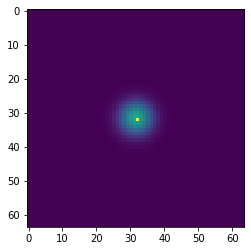

In [4]:
img = np.zeros(shape=(64,64,1), dtype=np.float32)
img = generate_heatmap([[32, 32]], [20], img_size=img.shape, sigma=0, strides=1)
print (type(img[...,0][0]))
plt.imshow(img)

### Test encoder
Encode input information to heatmaps   
i.e. for [0.,250.,250.,20.,40.] input values generate the corresponding heatmaps with given class number + size + offset values, with , hight   

gt: [0.0, 250.0, 250.0, 20.0, 40.0]
gt_scaled: [0.0, 62.0, 62.0, 5.0, 10.0]
ec_scaled: [0.0, 62.0, 62.0, 20.0, 40.0] 
===
gt: [2.0, 150.0, 200.0, 30.0, 50.0]
gt_scaled: [2.0, 37.0, 50.0, 7.0, 12.0]
ec_scaled: [2.0, 37.0, 50.0, 30.0, 50.0] 
===
gt: [1.0, 20.0, 50.0, 50.0, 20.0]
gt_scaled: [1.0, 5.0, 12.0, 12.0, 5.0]
ec_scaled: [1.0, 5.0, 12.0, 50.0, 20.0] 
===


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3) <class 'numpy.float32'>


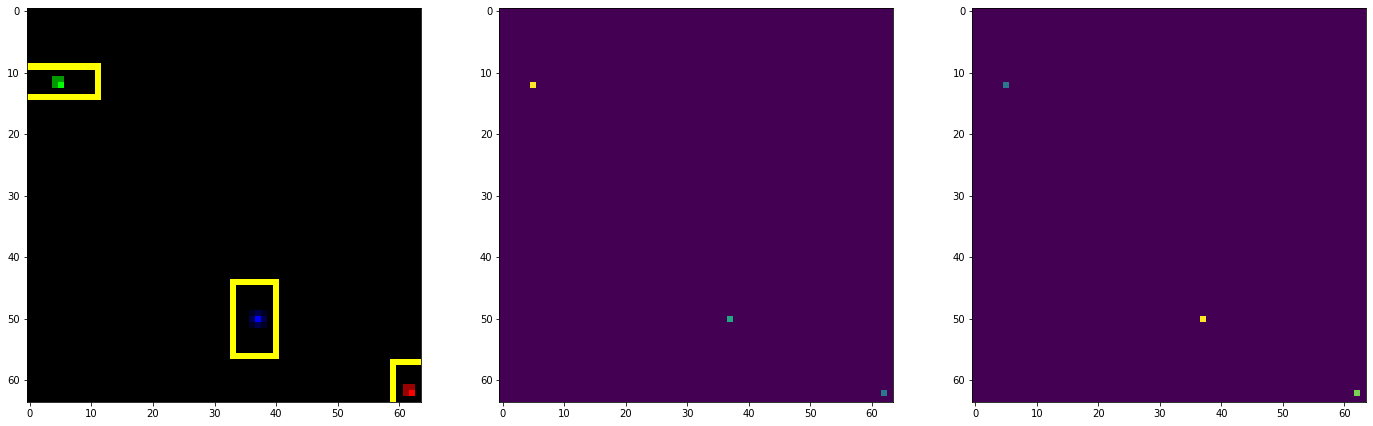

In [5]:
# test the encoder
gt = [[0.,250.,250.,20.,40.], [2.,150.,200.,30.,50.], [1.,20.,50.,50.,20.]]

a,b,c = encoder_wrapper([256,256,3], strides=4, classes=3, normalize=False, sigma=0)(gt)

img = a[...,:]

for g in gt:
    print ("gt:",g)
    _,x,y,w,h = np.array(g).astype(np.float32) //4
    _,xo,yo,wo,ho = np.array(g).astype(np.float32) / 4
    print ("gt_scaled:",[g[0],x,y,w,h])
    x1 = int(x - w/2)
    y1 = int(y - h/2) 
    x2 = int(x + w/2) 
    y2 = int(y + h/2)

    
    # codeded
    ww = c[int(y), int(x),0]
    hh = c[int(y), int(x),1]

    print ("ec_scaled:",[g[0],x,y,ww,hh], "\n===")
    
    img = cv2.rectangle(img, (x1,y1), (x2,y2), [255,255,0], 1)

fig, ax = plt.subplots(1, 3, figsize=(24, 8))
print (a.shape, type(a[...,0][0][0]))
ax[0].imshow(img)
ax[1].imshow(c[...,0])
ax[2].imshow(c[...,1])


In [6]:
def gen_traning_data(samples_nr=1000, iw=128,ih=128,obj_min=30,obj_max=60, nr_obj=3, nr_classes=3, dist_overlay=30, normalize=False):
    """ generate traning data - rectangles with different size, return img and position"""
    
    imgs = np.zeros((samples_nr,iw,ih,3),dtype=np.uint8)
    colors = [[255,0,0],[0,255,0],[0,0,255],[255,255,0],[255,0,255],[0,255,255]]
    vals = []
            
    # generate random samples
    for i in range (samples_nr):
        shapetype = 0
        
        samples = (np.random.random(size=(iw,ih,3)) *1000).astype(np.ubyte)
        b_kernel = np.dot(np.random.choice([3,5,7,9,11,13,17]),np.array([1,1]))

        samples = cv2.blur(samples,tuple(b_kernel))
        imgs[i] += samples
        if normalize == True:
            imgs[i] = (imgs[i]-np.min(imgs[i]))/(np.max(imgs[i])-np.min(imgs[i])) * 255

        dist_history = []
        vals_loc = []
        for j in range (nr_obj):
            # generate basic shape information
            ow = np.random.randint(obj_min,obj_max,dtype=np.int32)
            oh = np.random.randint(obj_min,obj_max,dtype=np.int32)

            # generate positions
            oposx = np.random.randint(int(ow/2),iw-ow,dtype=np.int32)
            oposy = np.random.randint(int(oh/2),ih-oh,dtype=np.int32)

            if len(dist_history) == 0:
                dist_history.append([oposx,oposy])
            else:
                # generate positions with defined distances
                done = True
                while done:
                    # generate positions
                    oposx = np.random.randint(int(ow/2),iw-ow,dtype=np.int32)
                    oposy = np.random.randint(int(oh/2),ih-oh,dtype=np.int32)

                    # check distance with existing one
                    for d in dist_history:
                        delta_x = np.abs(oposx - d[0])
                        delta_y = np.abs(oposy - d[1])
                        
                        if (delta_x <= dist_overlay) and (delta_x<=dist_overlay):
                            # position not found
                            oposx = 0
                            oposy = 0
                            
                    # check end condition
                    if (oposx > 0) and (oposy > 0):
                        dist_history.append([oposx,oposy])
                        done = False
                            
            # generate random between [0,5]
            clord = np.random.randint(0,6,dtype=np.int32)
            color = colors[clord]
    
            # 0 - circle, 1 - retangle , 2 - triangle
            k = np.random.randint(0,nr_classes,dtype=np.int32)
    
            if k == 0:
                r = int(min(ow/2,oh/2))
                ow = 2*r
                oh = 2*r
                cv2.circle(imgs[i],(oposx,oposy),r,color,-1)
                shapetype = 0
            elif k==1:
                cv2.rectangle(imgs[i],(oposx,oposy),(oposx+ow,oposy+oh),color,-1)
                shapetype = 1
            elif k==2:
                triangle_points= np.array([[oposx,oposy],[oposx+ow,oposy],[oposx,oposy+oh]],dtype=np.int32)
                cv2.drawContours(imgs[i], [triangle_points], 0, color, -1)
                shapetype = 2

            if k > 0:
                oposx = oposx + ow//2
                oposy = oposy + oh//2

            #imgs, array([shapetype, xc,yc, w,h])
            vals_loc.append([shapetype, oposx, oposy, ow, oh])
        vals.append(vals_loc)
    vals = np.array(vals)                    
    return imgs, vals

class DataGen(keras.utils.Sequence):
    def __init__(self, data_len, batch_size, img_shape, orig_img_shape=[256,256], strides=4, class_nr=1):
        self.batch_size = batch_size
        self.data_len = data_len
        self.img_shape = img_shape
        self.orig_img_shape = orig_img_shape
        self.strides = strides
        self.class_nr = class_nr

    # get data lenght
    def __len__(self):
        return self.data_len//self.batch_size
    
    # get item form batch
    def __getitem__(self, indx):

        X = []
        labels_hm = []
        labels_offs = []
        labels_sizes = []

        # imgs,pos,shapetype,shapecolor 
        X, val_list = gen_traning_data(self.batch_size,iw=self.img_shape[0], ih=self.img_shape[1], obj_min=30, obj_max=120, nr_obj=nr_gen_obj_on_img, nr_classes=self.class_nr, dist_overlay=10, normalize=True) 


        for nval_list in val_list:
            fact_y = self.orig_img_shape[0] / self.img_shape[0]
            fact_x = self.orig_img_shape[1] / self.img_shape[1]

            heat_map, offset_map, size_map = encoder_wrapper(input_shape=self.img_shape, strides=self.strides, classes=len(stype_lab),
                                             sigma=0, normalize=False)(nval_list)
            
            labels_hm.append(heat_map)
            labels_offs.append(offset_map)
            labels_sizes.append(size_map)
        
        X = np.array(X)

        labels_hm = np.array(labels_hm)
        labels_offs = np.array(labels_offs)
        labels_sizes = np.array(labels_sizes)

        # hm x size x offset,w,h
        out = np.concatenate([labels_hm, labels_sizes, labels_offs], axis=-1)
        out = np.transpose(out, [0,3,2,1])
        
        return X, out

# generate traning samples
obj_data_train = DataGen(3000,batch_size, img_shape=[256,256,3], orig_img_shape=[256,256,3], class_nr=num_classes)
obj_data_val = DataGen(600,batch_size, img_shape=[256,256,3], orig_img_shape=[256,256,3], class_nr=num_classes)
obj_data_tst = DataGen(200,batch_size, img_shape=[256,256,3], orig_img_shape=[256,256,3], class_nr=num_classes)

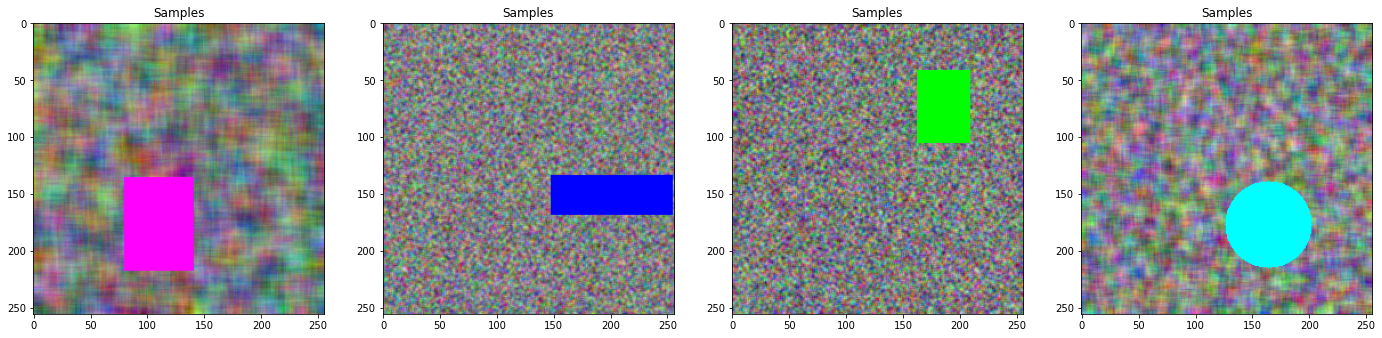

In [7]:
# show results
fig, ax = plt.subplots(1, batch_size//4, figsize=(24, 8))

for idx in range(batch_size//4):
    tst = obj_data_tst[0]
    rimg = tst[0][idx]
    ax[idx].set_title("Samples")
    ax[idx].imshow((rimg).astype(np.uint8))


### Centernet loss functions
Combines heatmap and regression losses

In [8]:
@tf.function
def centernet_tiny_loss(y_true, y_pred):

    # prepare hms, b, c x size x off, w,h
    hm_gt = y_true[:,0:num_classes,:,:]
    hm_gt_t = tf.transpose(hm_gt,[0,3,2,1])
    
    hm_pred = y_pred[:,0:num_classes,:,:]
    hm_pred_t = tf.transpose(hm_pred,[0,3,2,1])
    
    hm_loss = wrapper_focal_loss_hm(4.0,6.0,0.1)(hm_gt_t,hm_pred_t)
        
    v_gt_size = tf.transpose(y_true[:,num_classes:num_classes+2,:,:], [0,3,2,1])
    v_pred_size = tf.transpose(y_pred[:,num_classes:num_classes+2,:,:], [0,3,2,1])

    size_loss = reg_loss_by_label(v_gt_size,v_pred_size,hm_gt_t, threshold=0.8)
    
    v_gt_offs = tf.transpose(y_true[:,num_classes+2:num_classes+4,:,:], [0,3,2,1])
    v_pred_offs = tf.transpose(y_pred[:,num_classes+2:num_classes+4,:,:], [0,3,2,1])

    offs_loss = reg_loss_by_label(v_gt_offs,v_pred_offs,hm_gt_t, threshold=0.8)
    
    return hm_loss +  0.8 * size_loss + offs_loss

### Helper to check the model preformance (IOU based)

In [9]:
def test_iou(model, data, num_classes, batch_size, plot_results=False):
    idx = 0
    threshold = 0.1

    iou_vals = []
    class_vals = []
    gt_total = 0

    for idx in range(batch_size):

        sample_hm =  data[1][idx][0:num_classes, :, :]
        sample_size = data[1][idx][num_classes:num_classes +2,:,:]
        sample_offs = data[1][idx][num_classes+2:num_classes+4,:,:]
        rimg = data[0][idx]

        timg = nms(np.expand_dims(sample_hm,0),(3,3))

        ret= model.predict(np.expand_dims(rimg, 0))

        # ret = batch, nr_classes + size + offset, w,h
        hm = ret[:,0:num_classes,:,:]
        hm = np.transpose(hm, [0,3,2,1])

        sizem = ret[:,num_classes:num_classes+2,:,:]
        sizem = np.transpose(sizem, [0,3,2,1])

        offsetm = ret[:,num_classes+2:num_classes+4,:,:]
        offsetm = np.transpose(offsetm, [0,3,2,1])

        # cls_nr+4, size // stride, size // stride
        gt = data[1][idx]
        gt = tf.expand_dims(gt,0)

        gt_hm = gt[:,0:num_classes,:,:]
        gt_hm = np.transpose(gt_hm, [0,3,2,1])

        gt_sizem = gt[:,num_classes:num_classes+2,:,:]
        gt_sizem = np.transpose(gt_sizem, [0,3,2,1])

        gt_offsetm = gt[:,num_classes+2:num_classes+4,:,:]
        gt_offsetm = np.transpose(gt_offsetm, [0,3,2,1])

        gt_batch_samples = decode_detections(gt_hm, gt_offsetm, gt_sizem, strides=end_strides, top_k=20)
        gt_total +=1

        batch_samples = decode_detections(hm, offsetm, sizem,strides=end_strides, top_k=20)

        for gtd in np.array(gt_batch_samples):
            gs, gc, gx, gy, gw, gh = gtd
            if gs >= threshold:

                gx1, gx2 = int(gx - gw // 2), int(gx + gw // 2)
                gy1, gy2 = int(gy - gh // 2), int(gy + gh // 2)

                rimg = cv2.circle(rimg, (int(gx), int(gy)), 2, [255,0,0], -1)

                rimg = cv2.rectangle(rimg, (gx1,gy1), (gx2,gy2), [255,255,0], 2)
                gname = list(label_ids.keys())[int(gc)]

                utils.puttext_bg(rimg,np.str(gname), position=(gx1,gy1))


            for d in np.array(batch_samples):
                s, c, x, y, w, h = d
                if s >= threshold:
                    x1, x2 = int(x - w // 2), int(x + w // 2)
                    y1, y2 = int(y - h // 2), int(y + h // 2)

                    rimg = cv2.circle(rimg, (int(x), int(y)), 2, [0,255,0], -1)

                    rimg = cv2.rectangle(rimg, (x1,y1), (x2,y2), [255,0,0], 2)
                    name = list(label_ids.keys())[int(c)]

                    # put test over the image
                    utils.puttext_bg(rimg,np.str(name), position=(x1,y1))

                    # check center distance
                    if (np.linalg.norm(np.array([gx,gy])-np.array([x,y])) < 10):
                        lval = compute_iou(np.expand_dims(np.array([gx,gy,gw,gh]),0), np.expand_dims(np.array([x,y,w,h]),0))
                        iou_vals.append(lval.numpy()[0][0])
                        if int(c) == int(gc):
                            class_vals.append(1)
                        else:
                            class_vals.append(0)

                        if plot_results:
                            # show results
                            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 8))
                            ax1.set_title("IOU:" + str(np.round(lval.numpy(),2)[0][0]) + ", conf:" + str(np.round(s,2)))
                            ax1.imshow((rimg).astype(np.uint8))

                            ax2.imshow(np.sum(hm[0],axis=-1))
                            ax2.set_title("object center heatmap")

                            ax3.imshow(offsetm[0][...,0])
                            ax3.set_title("object width")

                            ax4.imshow(offsetm[0][...,1])
                            ax4.set_title("object height")


                            ax1.axis('off')
                            ax2.axis('off')
                            ax3.axis('off')
                            ax4.axis('off')
                            plt.show()
    return class_vals, iou_vals

 
class IntervalEvaluation(Callback):
    """
    Check IOU accuracy on epochs end.
    Exit traning if target accuracy reached. 
    """
    def __init__(self, model,validation_data=(), interval=1, strides=0):
        super(Callback, self).__init__()

        self.interval = interval
        self.target = 0.91
        self.log = []

    def on_epoch_end(self, epoch, logs={}):
        
        if epoch % self.interval == 0:
            
            class_vals, iou_vals = test_iou(centernet_tiny, obj_data_tst[0],num_classes,batch_size,plot_results=False)
            mean = np.mean(iou_vals,0) if len(iou_vals)>0 else 0.0
            self.log.append(mean)
            tf.print ("======>IOU:",mean)
            
            if mean >= self.target:
                self.model.stop_training = True
                print ("========early stopping============")

i_eval = IntervalEvaluation(centernet_tiny, validation_data=obj_data_tst[0], interval=1)

optimizer = tf.optimizers.RMSprop(learning_rate=1e-4, momentum=0.3, epsilon=1e-6)
centernet_tiny.compile(loss=centernet_tiny_loss, 
                  loss_weights=[1.0], 
                  optimizer=optimizer,run_eagerly=True, metrics=[])


### Train the model

In [10]:
hist = []
epochs = 300

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='centernet_tiny.h5',
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        monitor="val_loss",
        min_delta = 1e-6,
    ),

    i_eval
    
]


hist =  centernet_tiny.fit(x=obj_data_train,
    validation_data=obj_data_val,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/300
187/187 [==============================] - ETA: 0s - loss: 92.6414
Epoch 00001: val_loss improved from inf to 217.17903, saving model to centernet_tiny.h5
======>IOU: 4.038468e-06
187/187 [==============================] - 44s 234ms/step - loss: 92.6414 - val_loss: 217.1790
Epoch 2/300
187/187 [==============================] - ETA: 0s - loss: 5.4649
Epoch 00002: val_loss improved from 217.17903 to 6.65894, saving model to centernet_tiny.h5
======>IOU: 0.0
187/187 [==============================] - 43s 228ms/step - loss: 5.4649 - val_loss: 6.6589
Epoch 3/300
187/187 [==============================] - ETA: 0s - loss: 4.5600
Epoch 00003: val_loss improved from 6.65894 to 5.15203, saving model to centernet_tiny.h5
======>IOU: 0.0
187/187 [==============================] - 43s 228ms/step - loss: 4.5600 - val_loss: 5.1520
Epoch 4/300
187/187 [==============================] - ETA: 0s - loss: 3.3354
Epoch 00004: val_loss improved from 5.15203 to 3.13262, saving model to centernet

Text(0.5, 1.0, 'IOU/epochs')

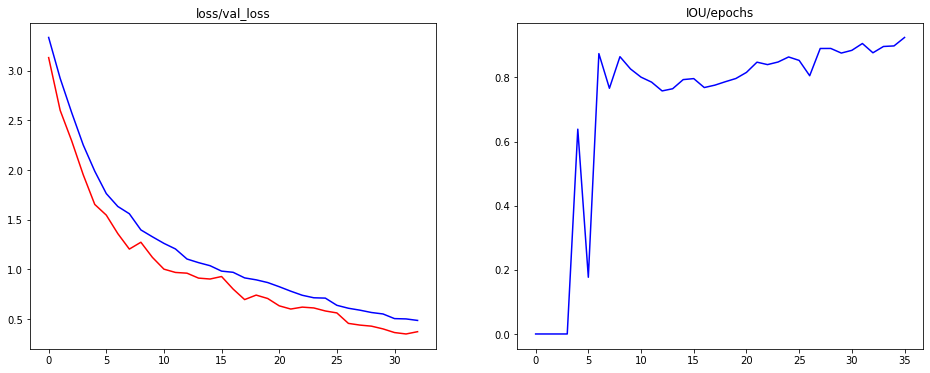

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(hist.history['loss'][3:], c='b')
ax[0].plot(hist.history['val_loss'][3:], c='r')
ax[0].set_title("loss/val_loss")

ax[1].plot(i_eval.log, c='b')
ax[1].set_title("IOU/epochs")


### Load the model, test it

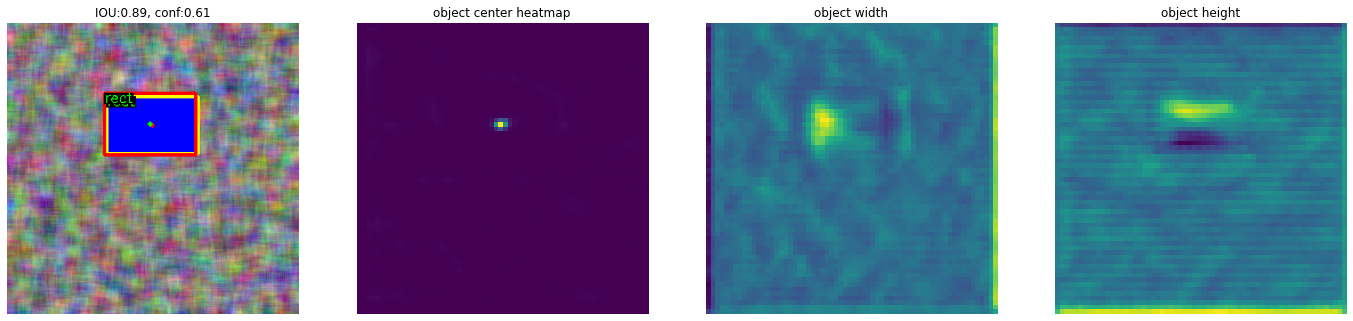

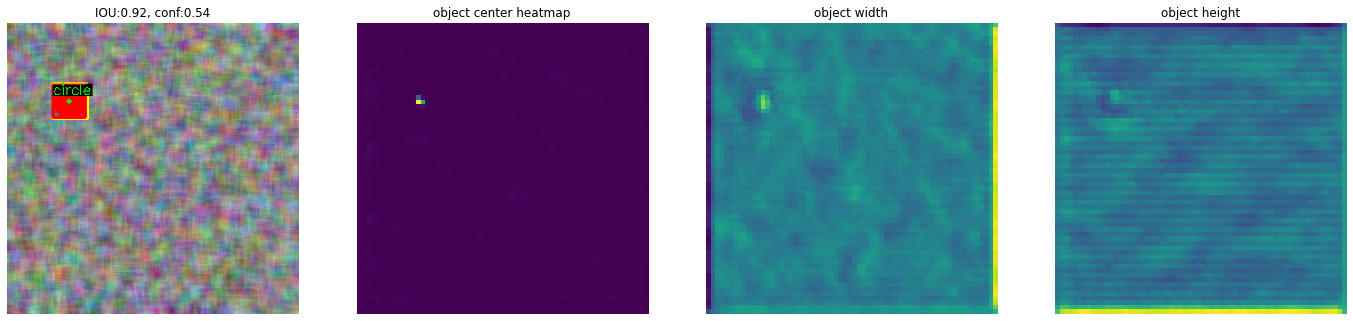

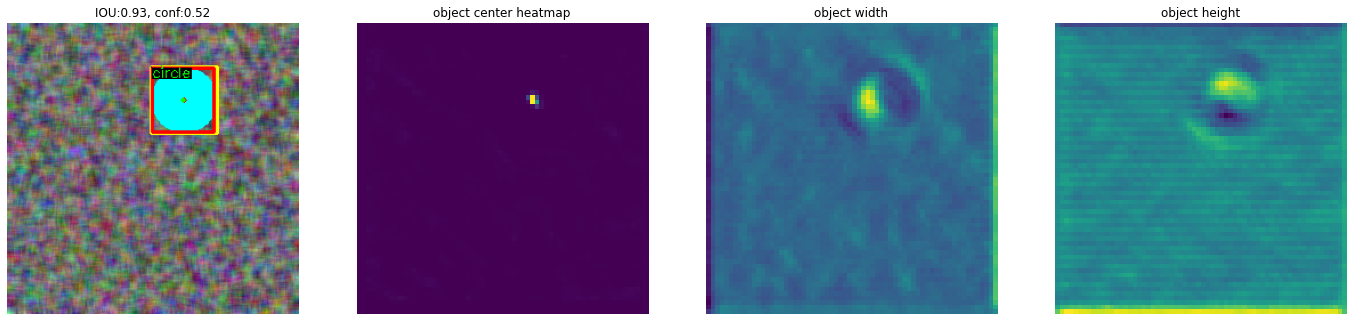

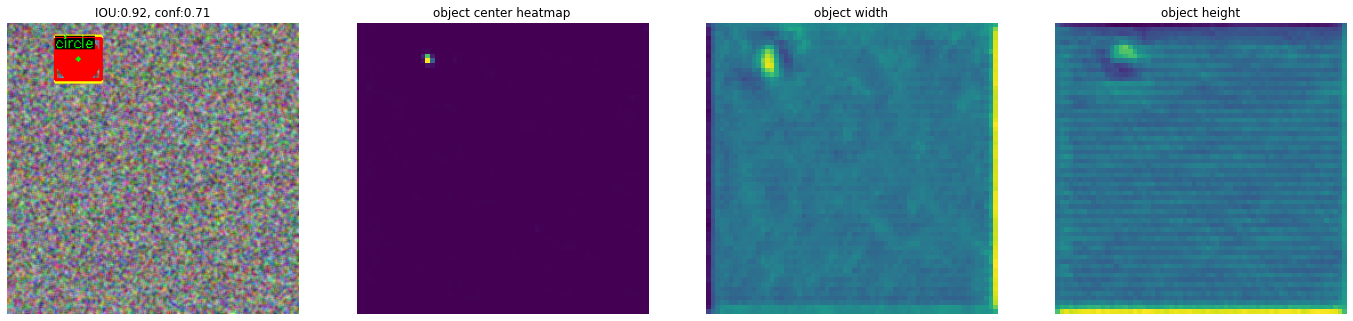

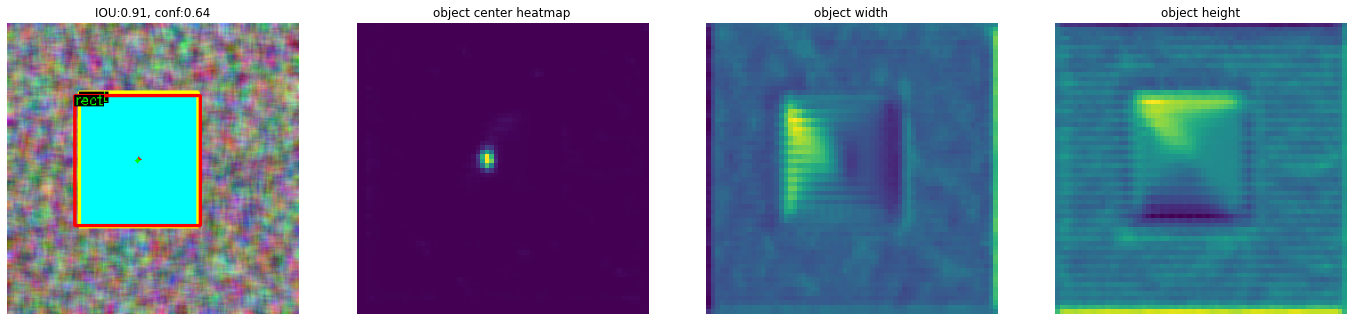

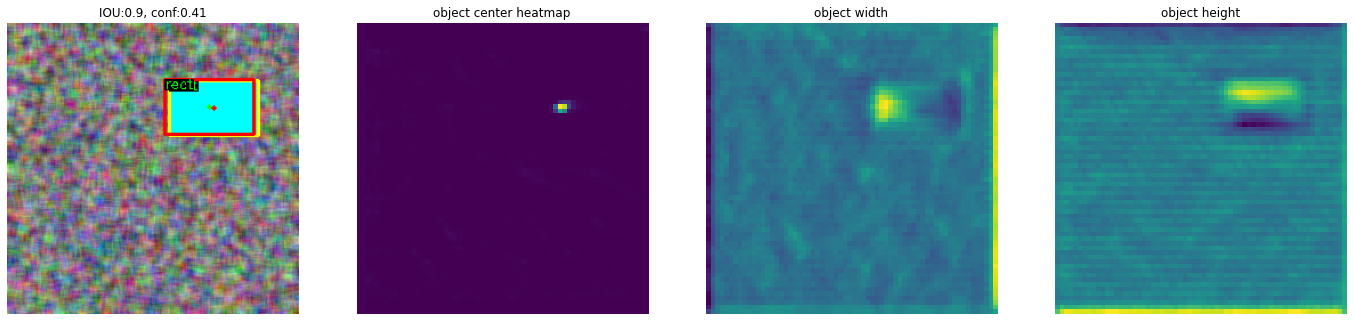

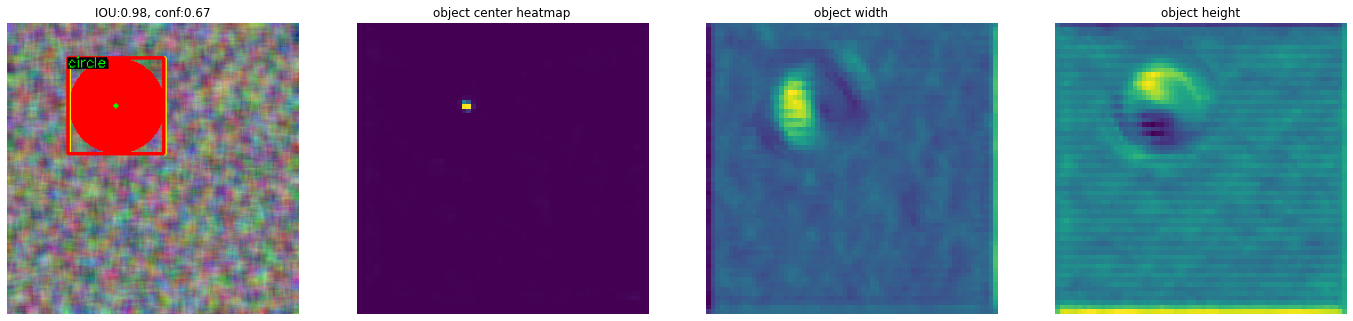

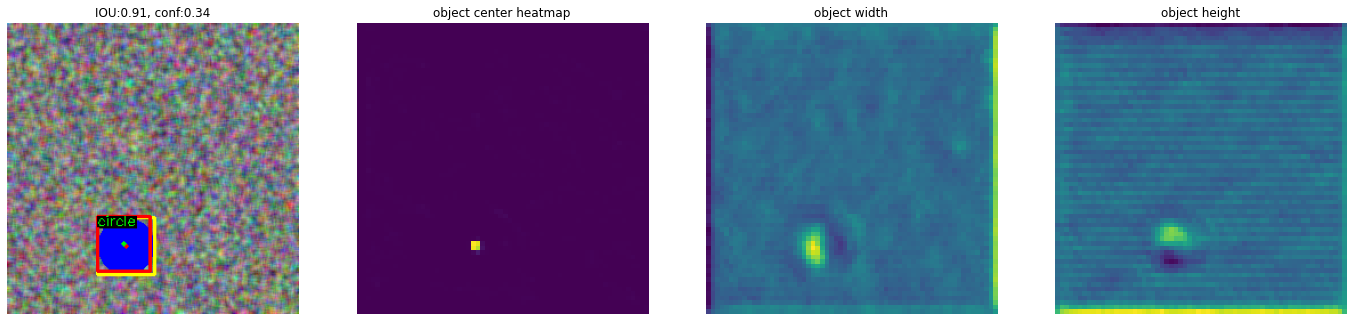

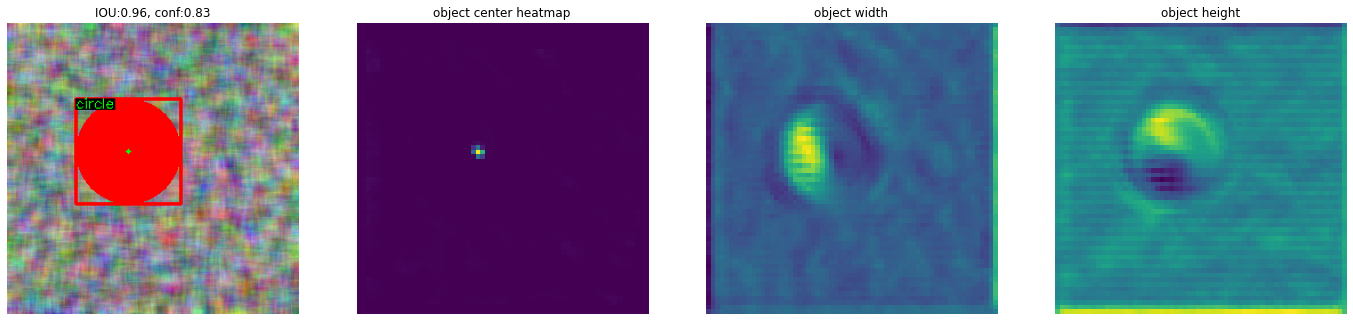

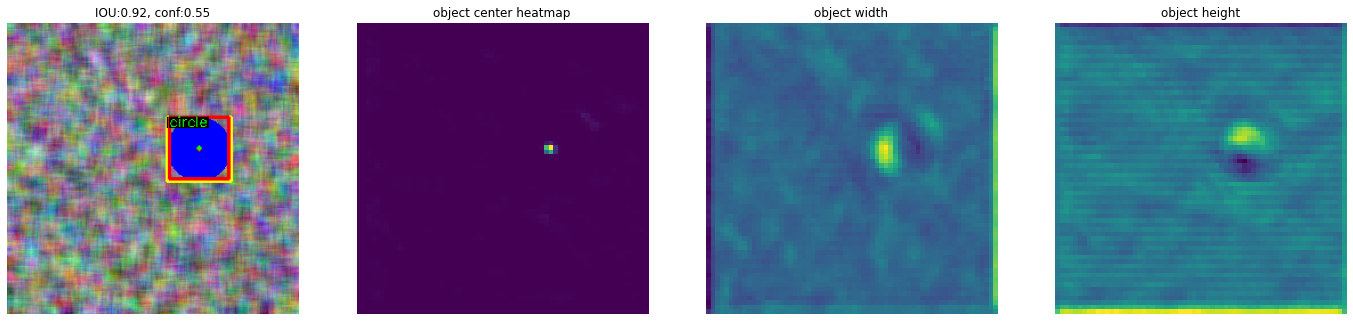

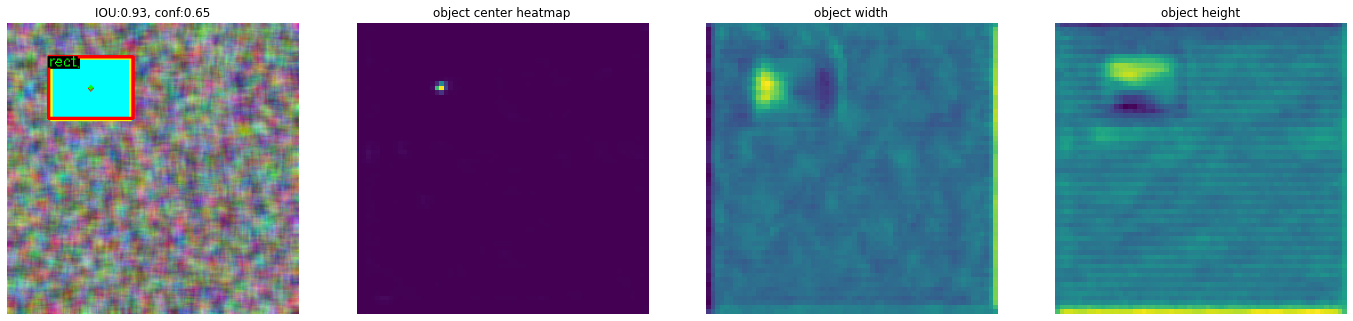

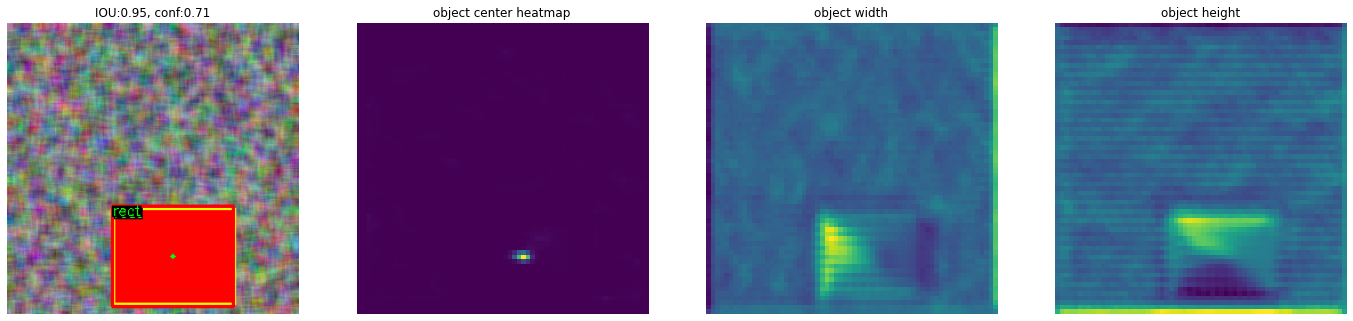

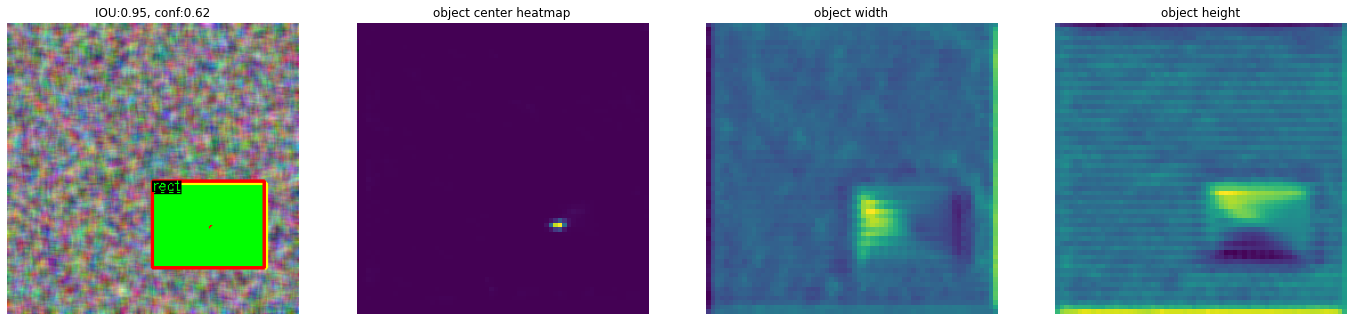

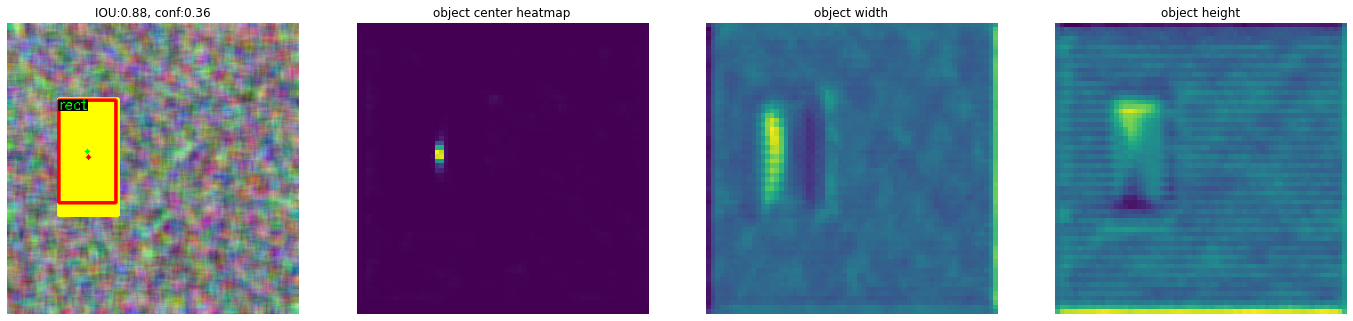

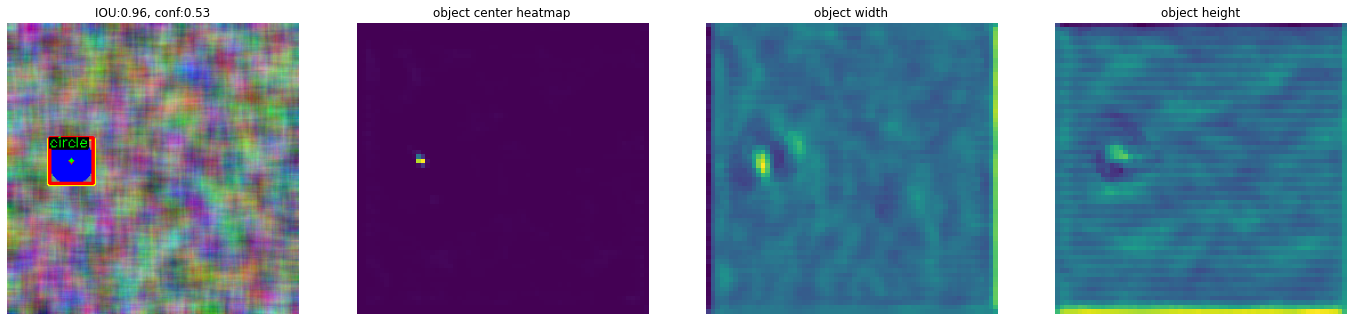

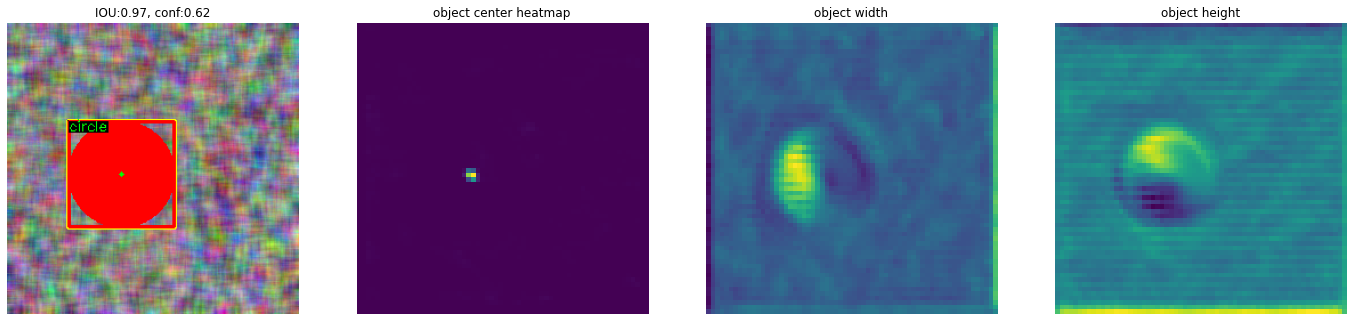

IOU: 93.10 %
Class Accuracy: 100.00 %, 


In [13]:
# load best model
test_model = keras.models.load_model("centernet_tiny.h5", compile=False)

class_vals, iou_vals = test_iou(test_model,obj_data_tst[0],num_classes,batch_size, True)

print ('IOU: {:.2f} %'.format(np.mean(iou_vals,0) *100))
print ('Class Accuracy: {:.2f} %, '.format(np.mean(class_vals,0) *100))